# 라이브러리 버전 확인

In [157]:
import os
import re
import pandas as pd
import numpy as np

import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from konlpy.tag import Okt
from konlpy.tag import Mecab
from collections import Counter
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 데이터 준비와 확인

In [2]:

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터로더 구성

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 모델 구성을 위한 데이터 분석 및 가공

In [7]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [8]:
# 적절한 최대 문장 길이 지정
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  48
전체 문장의 0.9548784420929768%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:

# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

# 모델 구성 및 validation set 구성

In [10]:

x_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지
partial_x_train = X_train[20000:]  
partial_y_train = y_train[20000:]

# 모델 훈련 개시 - LSTM

In [11]:
vocab_size = 10000
word_vector_dim = 128

LSTM_ = keras.Sequential()
LSTM_.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_.add(keras.layers.LSTM(128))
LSTM_.add(keras.layers.Dense(1, activation='sigmoid'))
LSTM_.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


In [12]:
LSTM_.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [14]:
LSTM_history = LSTM_.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    callbacks=[early, check],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
3944/3944 [==============================] - 25s 6ms/step - loss: 0.3631 - accuracy: 0.8390 - val_loss: 0.3192 - val_accuracy: 0.8620

Epoch 00001: saving model to best_model.h5
Epoch 2/20
3944/3944 [==============================] - 22s 6ms/step - loss: 0.2787 - accuracy: 0.8823 - val_loss: 0.3091 - val_accuracy: 0.8676

Epoch 00002: saving model to best_model.h5
Epoch 3/20
3944/3944 [==============================] - 22s 6ms/step - loss: 0.2358 - accuracy: 0.9030 - val_loss: 0.3192 - val_accuracy: 0.8678

Epoch 00003: saving model to best_model.h5
Epoch 4/20
3944/3944 [==============================] - 22s 6ms/step - loss: 0.1965 - accuracy: 0.9211 - val_loss: 0.3442 - val_accuracy: 0.8620

Epoch 00004: saving model to best_model.h5
Epoch 5/20
3944/3944 [==============================] - 22s 6ms/step - loss: 0.1597 - accuracy: 0.9368 - val_loss: 0.3847 - val_accuracy: 0.8630

Epoch 00005: saving model to best_model.h5
Epoch 6/20
3944/3944 [==============================] -

In [15]:
loaded_model = load_model('best_model.h5')
results = loaded_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.5070 - accuracy: 0.8500
[0.5070101022720337, 0.8500315546989441]


#  Loss, Accuracy 그래프 시각화

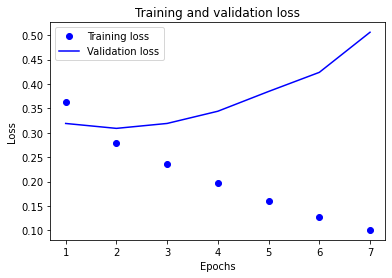

In [16]:
LSTM_history_dict = LSTM_history.history
acc = LSTM_history_dict['accuracy']
val_acc = LSTM_history_dict['val_accuracy']
loss = LSTM_history_dict['loss']
val_loss = LSTM_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

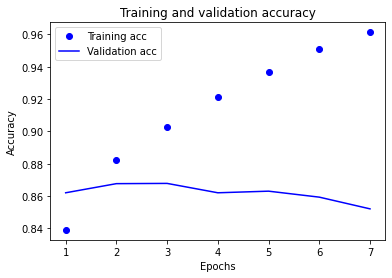

In [17]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 학습된 Embedding 레이어 분석

In [18]:
embedding_layer = LSTM_.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 128)


In [20]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/LSTMword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = LSTM_.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['끝']
vector

array([ 0.07617019, -0.06024291, -0.13287221, -0.16275209, -0.02542715,
        0.02228842,  0.1978102 ,  0.05959954, -0.22555318, -0.09787603,
        0.07416858, -0.33354527,  0.02462749,  0.01689578,  0.13821465,
       -0.00061071,  0.12270303,  0.13865067,  0.02995373, -0.22553198,
       -0.09742033, -0.0812258 ,  0.04407963,  0.22939949,  0.00081855,
       -0.01818942, -0.12126928, -0.02962148, -0.07552838, -0.22581922,
        0.03173481,  0.20780964, -0.09264218, -0.00936599,  0.01049715,
        0.16604188,  0.27480403,  0.03680809,  0.13428807, -0.05505793,
       -0.3014152 ,  0.08498043,  0.138511  , -0.01532526, -0.05507532,
       -0.09752958,  0.0189063 , -0.00389729,  0.18533733, -0.0170551 ,
        0.18847637,  0.04880574,  0.08692499, -0.09745834,  0.01343251,
       -0.06265919,  0.30496255, -0.07583974,  0.05996573,  0.1028078 ,
        0.30630115,  0.06399857,  0.13250867, -0.03931529, -0.19052556,
       -0.01225637, -0.04521476, -0.2710471 ,  0.07288661, -0.02

In [21]:
word_vectors.similar_by_word("끝")

[('려는지', 0.7059453725814819),
 ('침몰', 0.6921941041946411),
 ('잠', 0.6866409182548523),
 ('잣', 0.6719169616699219),
 ('산', 0.6705135703086853),
 ('그렇', 0.6696851849555969),
 ('귀신', 0.6637470722198486),
 ('명성', 0.6584715247154236),
 ('에다', 0.6560390591621399),
 ('부처', 0.6546027660369873)]

# 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [87]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
import os

# 한국어 Word2Vec 사용
word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv['끝']

In [97]:
word_vectors.wv.similar_by_word('끝')

[('마지막', 0.6325399875640869),
 ('결판', 0.5526015758514404),
 ('발목', 0.5465342402458191),
 ('산산조각', 0.5418900847434998),
 ('막바지', 0.5412753820419312),
 ('싫증', 0.5256820917129517),
 ('양쪽', 0.5253474116325378),
 ('무릎', 0.5246764421463013),
 ('후', 0.5051813721656799),
 ('이어진', 0.5038793087005615)]

In [105]:
vocab_size = vocab_size
word_vector_dim = word_vectors.wv.vectors.shape[1]

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
print('embedding_matrix.shape: ', embedding_matrix.shape)

embedding_matrix.shape:  (10000, 100)


In [106]:
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [109]:
vocab_size = 10000
word_vector_dim = 100

LSTM_ko = keras.Sequential()
LSTM_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
LSTM_ko.add(keras.layers.LSTM(64))
LSTM_ko.add(keras.layers.Dense(256, activation='relu'))
LSTM_ko.add(keras.layers.Dense(1, activation='sigmoid'))

In [110]:
LSTM_ko.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 48, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 1,059,137
Trainable params: 1,059,137
Non-trainable params: 0
_________________________________________________________________


In [111]:
LSTM_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [116]:
ealry_ko = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check_ko = ModelCheckpoint('best', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [113]:
history = LSTM_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    callbacks=[ealry_ko, check_ko],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
3944/3944 [==============================] - 22s 5ms/step - loss: 0.3971 - accuracy: 0.8175 - val_loss: 0.3379 - val_accuracy: 0.8540

Epoch 00001: saving model to best_model_ko.h5
Epoch 2/20
3944/3944 [==============================] - 20s 5ms/step - loss: 0.3043 - accuracy: 0.8695 - val_loss: 0.3159 - val_accuracy: 0.8636

Epoch 00002: saving model to best_model_ko.h5
Epoch 3/20
3944/3944 [==============================] - 20s 5ms/step - loss: 0.2676 - accuracy: 0.8877 - val_loss: 0.3272 - val_accuracy: 0.8621

Epoch 00003: saving model to best_model_ko.h5
Epoch 4/20
3944/3944 [==============================] - 20s 5ms/step - loss: 0.2396 - accuracy: 0.9013 - val_loss: 0.3222 - val_accuracy: 0.8667

Epoch 00004: saving model to best_model_ko.h5
Epoch 5/20
3944/3944 [==============================] - 20s 5ms/step - loss: 0.2120 - accuracy: 0.9139 - val_loss: 0.3498 - val_accuracy: 0.8652

Epoch 00005: saving model to best_model_ko.h5
Epoch 6/20
3944/3944 [==================

In [118]:
loaded_model = load_model('best_model_ko.h5')
results = loaded_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3962 - accuracy: 0.8568
[0.39624127745628357, 0.8568260669708252]


# LSTM 에서 정확도 85프로 넘음!

# 다른 모델로 학습2 - conv1d

In [119]:
vocab_size = 10000
word_vector_dim = 64

conv1d_model = keras.Sequential()
conv1d_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
conv1d_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model.add(keras.layers.MaxPooling1D(5))
conv1d_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model.add(keras.layers.GlobalMaxPooling1D())
conv1d_model.add(keras.layers.Dense(128, activation='relu'))
conv1d_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [120]:
conv1d_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [121]:
conv1d_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [122]:
conv1d_history = conv1d_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3944/3944 [==============================] - 20s 5ms/step - loss: 0.4081 - accuracy: 0.8064 - val_loss: 0.3654 - val_accuracy: 0.8313
Epoch 2/10
3944/3944 [==============================] - 18s 4ms/step - loss: 0.3100 - accuracy: 0.8617 - val_loss: 0.3653 - val_accuracy: 0.8357
Epoch 3/10
3944/3944 [==============================] - 18s 4ms/step - loss: 0.2336 - accuracy: 0.8986 - val_loss: 0.3994 - val_accuracy: 0.8251
Epoch 4/10
3944/3944 [==============================] - 18s 4ms/step - loss: 0.1680 - accuracy: 0.9282 - val_loss: 0.4903 - val_accuracy: 0.8255
Epoch 5/10
3944/3944 [==============================] - 18s 5ms/step - loss: 0.1281 - accuracy: 0.9440 - val_loss: 0.6200 - val_accuracy: 0.8166
Epoch 6/10
3944/3944 [==============================] - 18s 5ms/step - loss: 0.1044 - accuracy: 0.9536 - val_loss: 0.6741 - val_accuracy: 0.8144
Epoch 7/10
3944/3944 [==============================] - 18s 4ms/step - loss: 0.0897 - accuracy: 0.9599 - val_loss: 0.7843 - val_ac

# conv1d시각화 하기

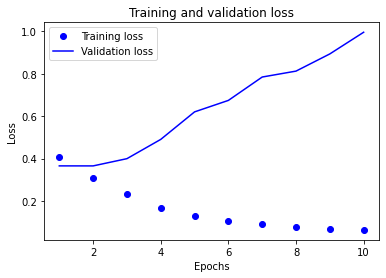

In [124]:
conv1d_history_dict = conv1d_history.history

acc = conv1d_history_dict['accuracy']
val_acc = conv1d_history_dict['val_accuracy']
loss = conv1d_history_dict['loss']
val_loss = conv1d_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

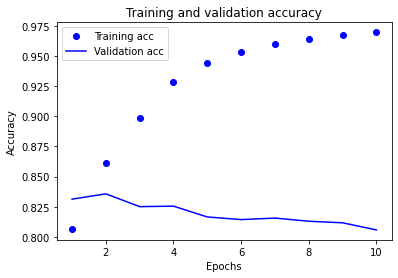

In [125]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 임베딩 레이어 확인

In [126]:
embedding_layer = conv1d_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 64)


In [127]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/conv1d_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = conv1d_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [128]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['끝']
vector

array([ 0.16039523, -0.21353234,  0.10053949,  0.0617637 ,  0.2400047 ,
        0.26146755,  0.22837314, -0.10810944,  0.10463615, -0.02049661,
       -0.04041705, -0.17160086, -0.06882595, -0.167664  , -0.06566158,
       -0.08431412,  0.03558896, -0.0332323 ,  0.01976864,  0.02681297,
       -0.08923274,  0.25031778,  0.08020499,  0.40995952, -0.18464011,
        0.01875813,  0.04290253, -0.07847054, -0.26605442,  0.11327574,
       -0.09676535, -0.06215183, -0.09975547, -0.10650266, -0.19519675,
       -0.10930956, -0.13824074, -0.11634096,  0.0882811 , -0.0992004 ,
        0.01642582, -0.12949279,  0.06588767, -0.00688476, -0.02480588,
       -0.2815041 , -0.00276024,  0.14318605, -0.04096439, -0.19097587,
        0.20809348, -0.05446141, -0.05613462,  0.09021642,  0.20740879,
        0.03693626,  0.30877876,  0.12369863, -0.17847647,  0.05291033,
        0.10100688,  0.03643023,  0.14495873,  0.3603014 ], dtype=float32)

In [129]:
word_vectors.similar_by_word("끝")

[('남편', 0.4832385778427124),
 ('킬러', 0.45728790760040283),
 ('맡', 0.45511457324028015),
 ('수입', 0.4423467218875885),
 ('로얄', 0.4383450150489807),
 ('불편', 0.3992714285850525),
 ('겄', 0.39129000902175903),
 ('당위', 0.3911603093147278),
 ('같잖', 0.3879825174808502),
 ('천녀', 0.3876078724861145)]

> 끝과 관련없는 단어들이 나오는듯

# conv1d 한국어 word2vec

In [134]:
vocab_size = 10000
word_vector_dim = 100

conv1d_model_ko = keras.Sequential()
conv1d_model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
conv1d_model_ko.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model_ko.add(keras.layers.MaxPooling1D(5))
conv1d_model_ko.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model_ko.add(keras.layers.GlobalMaxPooling1D())
conv1d_model_ko.add(keras.layers.Dense(128, activation='relu'))
conv1d_model_ko.add(keras.layers.Dense(1, activation='sigmoid'))
conv1d_model_ko = keras.Sequential()
conv1d_model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
conv1d_model_ko.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model_ko.add(keras.layers.MaxPooling1D(5))
conv1d_model_ko.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model_ko.add(keras.layers.GlobalMaxPooling1D())
conv1d_model_ko.add(keras.layers.Dense(128, activation='relu'))
conv1d_model_ko.add(keras.layers.Dense(1, activation='sigmoid'))

In [135]:
conv1d_model_ko.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 48, 100)           1000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 42, 64)            44864     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 2, 64)             28736     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_10 (Dense)             (None, 1)               

In [136]:
conv1d_model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [137]:
history = conv1d_model_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3944/3944 [==============================] - 19s 5ms/step - loss: 0.6934 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 2/10
3944/3944 [==============================] - 18s 5ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 3/10
3944/3944 [==============================] - 18s 5ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 4/10
3944/3944 [==============================] - 18s 5ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 5/10
3944/3944 [==============================] - 18s 5ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 6/10
3944/3944 [==============================] - 18s 5ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 7/10
3944/3944 [==============================] - 18s 5ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_ac

In [139]:
results = conv1d_model_ko.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6931 - accuracy: 0.5027
[0.6931345462799072, 0.5026954412460327]


# 다른모델로 학습 - GlobalMaxPooling

In [140]:
vocab_size = 10000
word_vector_dim = 64

GMP_model = keras.Sequential()
GMP_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(keras.layers.GlobalMaxPooling1D())
GMP_model.add(keras.layers.Dense(8, activation='relu'))
GMP_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [141]:
GMP_model.summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 64)          640000    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 9         
Total params: 640,529
Trainable params: 640,529
Non-trainable params: 0
_________________________________________________________________


In [142]:
GMP_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [143]:
GMP_history = GMP_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3944/3944 [==============================] - 12s 3ms/step - loss: 0.3883 - accuracy: 0.8271 - val_loss: 0.3407 - val_accuracy: 0.8491
Epoch 2/10
3944/3944 [==============================] - 12s 3ms/step - loss: 0.3028 - accuracy: 0.8729 - val_loss: 0.3399 - val_accuracy: 0.8529
Epoch 3/10
3944/3944 [==============================] - 12s 3ms/step - loss: 0.2621 - accuracy: 0.8925 - val_loss: 0.3461 - val_accuracy: 0.8530
Epoch 4/10
3944/3944 [==============================] - 12s 3ms/step - loss: 0.2275 - accuracy: 0.9088 - val_loss: 0.3637 - val_accuracy: 0.8536
Epoch 5/10
3944/3944 [==============================] - 12s 3ms/step - loss: 0.1967 - accuracy: 0.9235 - val_loss: 0.3883 - val_accuracy: 0.8533
Epoch 6/10
3944/3944 [==============================] - 12s 3ms/step - loss: 0.1690 - accuracy: 0.9358 - val_loss: 0.4162 - val_accuracy: 0.8462
Epoch 7/10
3944/3944 [==============================] - 12s 3ms/step - loss: 0.1446 - accuracy: 0.9459 - val_loss: 0.4594 - val_ac

In [144]:
results = GMP_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6252 - accuracy: 0.8320
[0.6252012848854065, 0.832007646560669]


# GlobalMaxPooling 시각화하기

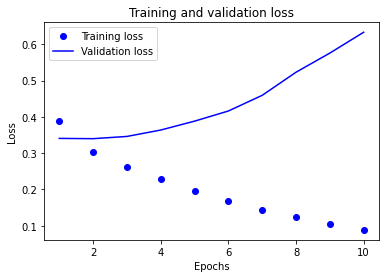

In [145]:
GMP_history_dict = GMP_history.history

acc = GMP_history_dict['accuracy']
val_acc = GMP_history_dict['val_accuracy']
loss = GMP_history_dict['loss']
val_loss = GMP_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

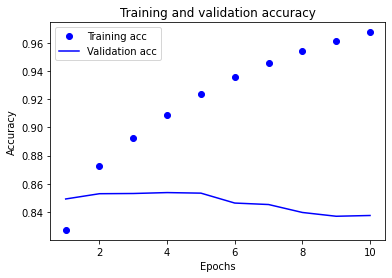

In [146]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 임베딩 레이어 확인

In [147]:
embedding_layer = GMP_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 64)


In [148]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GMP_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = GMP_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [149]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['끝']
vector

array([-0.10244824, -0.28594005,  0.11942941, -0.28585786, -0.1497088 ,
        0.18949145,  0.04420587,  0.18005057, -0.17507936, -0.06566776,
       -0.11658733, -0.3035672 , -0.06402057,  0.05386945,  0.19411184,
       -0.26252908,  0.40122387, -0.30099767,  0.00256908,  0.14115205,
       -0.3358133 , -0.08131809, -0.26120603, -0.23069729,  0.1376882 ,
        0.04416883, -0.1907152 , -0.22638771, -0.27925807, -0.2570674 ,
       -0.06754725,  0.03859064,  0.1085866 ,  0.06907428,  0.34949356,
       -0.25189197, -0.14682236, -0.17351991, -0.12339093, -0.0733835 ,
       -0.27116162, -0.2620234 , -0.24622717, -0.3250539 , -0.20248803,
       -0.23745978,  0.18299411, -0.21263902, -0.27675757, -0.10166692,
       -0.34334803, -0.23566402, -0.08478175, -0.19778241, -0.25496563,
       -0.04225265, -0.17496586, -0.11705191, -0.31119093, -0.21275844,
       -0.1111219 , -0.29632914, -0.19299945, -0.34695885], dtype=float32)

In [150]:
word_vectors.similar_by_word("끝")

[('객관', 0.6718366742134094),
 ('자아', 0.6569578647613525),
 ('까지', 0.6337772011756897),
 ('_', 0.6262025237083435),
 ('니', 0.6233547925949097),
 ('흑백', 0.6221472024917603),
 ('이거', 0.6214049458503723),
 ('성장', 0.6165032982826233),
 ('떄', 0.6043305397033691),
 ('고', 0.6023388504981995)]

> 얘도 끝이랑 관련없는 단어들이 나옴

# 한국어 word2vec

In [152]:
vocab_size = 10000
word_vector_dim = 100

GMP_model_ko = keras.Sequential()
GMP_model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
GMP_model_ko.add(keras.layers.GlobalMaxPooling1D())
GMP_model_ko.add(keras.layers.Dense(8, activation='relu'))
GMP_model_ko.add(keras.layers.Dense(1, activation='sigmoid'))

In [153]:
GMP_model_ko.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 48, 100)           1000000   
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 808       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [154]:
GMP_model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [155]:
history = GMP_model_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3944/3944 [==============================] - 13s 3ms/step - loss: 0.4311 - accuracy: 0.7988 - val_loss: 0.3610 - val_accuracy: 0.8410
Epoch 2/10
3944/3944 [==============================] - 12s 3ms/step - loss: 0.3149 - accuracy: 0.8661 - val_loss: 0.3352 - val_accuracy: 0.8553
Epoch 3/10
3944/3944 [==============================] - 12s 3ms/step - loss: 0.2767 - accuracy: 0.8858 - val_loss: 0.3432 - val_accuracy: 0.8522
Epoch 4/10
3944/3944 [==============================] - 12s 3ms/step - loss: 0.2472 - accuracy: 0.9003 - val_loss: 0.3535 - val_accuracy: 0.8529
Epoch 5/10
3944/3944 [==============================] - 12s 3ms/step - loss: 0.2199 - accuracy: 0.9133 - val_loss: 0.3806 - val_accuracy: 0.8450
Epoch 6/10
3944/3944 [==============================] - 12s 3ms/step - loss: 0.1944 - accuracy: 0.9253 - val_loss: 0.3907 - val_accuracy: 0.8495
Epoch 7/10
3944/3944 [==============================] - 12s 3ms/step - loss: 0.1707 - accuracy: 0.9362 - val_loss: 0.4163 - val_ac

In [156]:
results = GMP_model_ko.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5457 - accuracy: 0.8328
[0.5457369089126587, 0.8328213691711426]
